# IMPORTS

In [9]:
from diffusion_imaging.handlers import make_handler
from dipy.segment.mask import median_otsu
from dipy.data.fetcher import fetch_mni_template, read_mni_template
from dipy.align.reslice import reslice
from dipy.align.imaffine import MutualInformationMetric, AffineRegistration, transform_origins
from dipy.align.transforms import TranslationTransform3D, RigidTransform3D, AffineTransform3D
from dipy.align.imwarp import SymmetricDiffeomorphicRegistration
from dipy.align.metrics import CCMetric
import numpy as np

# PATIENT SIDE

## Load Patient

In [15]:
hcp_handler = make_handler('D:\\Users\\boywi\\Documents\\THESIS_DATA\\HCP\\Diffusion\\100307\\T1w\\Diffusion', 'hcp')
patient = hcp_handler.load()

['D:\\Users\\boywi\\Documents\\THESIS_DATA\\HCP\\Diffusion\\100307\\T1w\\Diffusion\\bvals', 'D:\\Users\\boywi\\Documents\\THESIS_DATA\\HCP\\Diffusion\\100307\\T1w\\Diffusion\\bvecs', 'D:\\Users\\boywi\\Documents\\THESIS_DATA\\HCP\\Diffusion\\100307\\T1w\\Diffusion\\data.nii.gz']


C:\Users\boywi\Miniconda3\envs\dmipy\lib\site-packages\dmipy-0.1.dev0-py3.7.egg\dmipy\core\acquisition_scheme.py:871: UserWarning: pulse_separation (big_delta) or pulse_duration (small_delta) are not defined in the Dipy gtab. This means the resulting DmipyAcquisitionScheme cannot be used with CompartmentModels that need these.


## Make mask

In [33]:
b0_idx_patient = np.where(patient.mri.gradient_table.b0s_mask)[0]
b0_data_patient = data[..., b0_idx_patient]
b0_masked_patient, _ = median_otsu(b0_data_patient,
                vol_idx=list(range(b0_data_patient.shape[-1])),
                median_radius=4, numpass=4)

## Compute Mean b0

In [34]:
mean_b0_masked_patient = np.mean(b0_masked_patient, 
                                 axis=3,
                                 dtype=patient.mri.data.dtype)

# MNI SIDE

## load mni

In [20]:
fetch_mni_template()
img_t1_mni = read_mni_template("a", contrast="T1")

Data size is approximately 70MB
Dataset is already in place. If you want to fetch it again please first remove the folder C:\Users\boywi\.dipy\mni_template 
Data size is approximately 70MB
Dataset is already in place. If you want to fetch it again please first remove the folder C:\Users\boywi\.dipy\mni_template 


## Reslice

In [50]:
def change_voxel_size(from_image, to_image):
    print(f"shape of image before: {from_image.get_fdata().shape}")
    i, j, k = to_image.header.get_zooms()
    new_zooms = (i, j, k)
    print(f"new zooms: {new_zooms}")
    new_from_data, affine = reslice(data=from_image.get_fdata(), 
                               affine=from_image.affine, 
                               zooms=from_image.header.get_zooms(), 
                               new_zooms=new_zooms)
    print(f"shape of image after: {new_from_data.shape}")
    
    return new_from_data, affine

# Get info for transformation

In [36]:
static = img_t1_mni.get_fdata()
static_affine = img_t1_mni.affine
moving = mean_b0_masked_patient
moving_affine = patient.mri.nifti_image.affine

# Map affine

In [37]:
affine_map = transform_origins(static, static_affine, moving, moving_affine)

# Specify mismatch metric

In [40]:
nbins = 32
sampling_prop = None
metric = MutualInformationMetric(nbins, sampling_prop)
level_iters = [10, 10, 5]
sigmas = [3.0, 1.0, 0.0]
factors = [4, 2, 1]

# Perform affine registration

In [42]:
affine_reg = AffineRegistration(metric=metric, level_iters=level_iters,
                                sigmas=sigmas, factors=factors)
transform = TranslationTransform3D()

params0 = None
translation = affine_reg.optimize(static, moving, transform, params0,
                                  static_affine, moving_affine)
transformed = translation.transform(moving)
transform = RigidTransform3D()

rigid_map = affine_reg.optimize(static, moving, transform, params0,
                                static_affine, moving_affine,
                                starting_affine=translation.affine)
transformed = rigid_map.transform(moving)
transform = AffineTransform3D()

Optimizing level 2 [max iter: 10]
Optimizing level 1 [max iter: 10]
Optimizing level 0 [max iter: 5]
Optimizing level 2 [max iter: 10]
Optimizing level 1 [max iter: 10]
Optimizing level 0 [max iter: 5]


In [44]:
affine_reg.level_iters = [1000, 1000, 100]
highres_map = affine_reg.optimize(static, moving, transform, params0,
                                  static_affine, moving_affine,
                                  starting_affine=rigid_map.affine)
transformed = highres_map.transform(moving)

Optimizing level 2 [max iter: 1000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]


# Perform non-rigid deformation

In [45]:
metric = CCMetric(3)
level_iters = [10, 10, 5]
sdr = SymmetricDiffeomorphicRegistration(metric, level_iters)

mapping = sdr.optimize(static, moving, static_affine, moving_affine,
                       highres_map.affine)
warped_moving = mapping.transform(moving)

Creating scale space from the moving image. Levels: 3. Sigma factor: 0.200000.
Creating scale space from the static image. Levels: 3. Sigma factor: 0.200000.
Optimizing level 2
Optimizing level 1
Optimizing level 0


# Show registration results

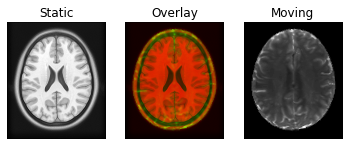

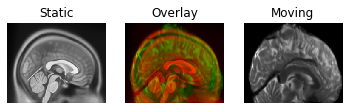

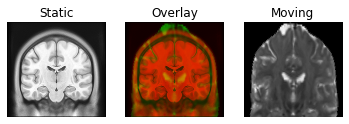

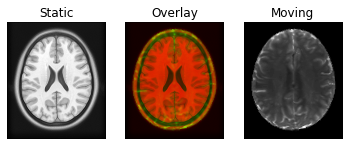

In [46]:
from dipy.viz import regtools

regtools.overlay_slices(static, warped_moving, None, 0, 'Static', 'Moving',
                        'transformed_sagittal.png')
regtools.overlay_slices(static, warped_moving, None, 1, 'Static', 'Moving',
                        'transformed_coronal.png')
regtools.overlay_slices(static, warped_moving, None, 2, 'Static', 'Moving',
                        'transformed_axial.png')

In [68]:
static.shape

(197, 233, 189)

In [69]:
warped_moving.shape

(197, 233, 189)

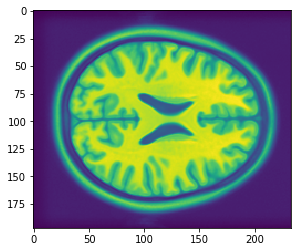

In [65]:
plt.imshow(static[..., 95])

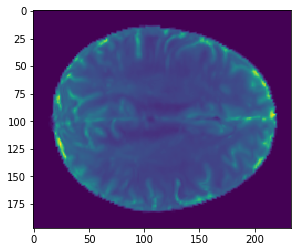

In [64]:
import matplotlib.pyplot as plt


plt.imshow(warped_moving[..., 95])

# Play around

In [7]:
import numpy as np
from dipy.viz import regtools
from dipy.data import fetch_stanford_hardi, read_stanford_hardi
from dipy.data.fetcher import fetch_syn_data, read_syn_data
from dipy.align.imaffine import (transform_centers_of_mass,
                                 AffineMap,
                                 MutualInformationMetric,
                                 AffineRegistration)
from dipy.align.transforms import (TranslationTransform3D,
                                   RigidTransform3D,
                                   AffineTransform3D)
from dipy.align.imaffine import (MutualInformationMetric, AffineRegistration,
                                 transform_origins)
from dipy.align.transforms import (TranslationTransform3D, RigidTransform3D,
                                   AffineTransform3D)

In [10]:
static = read_mni_template("a", contrast="T1")
static = static.get_data()

Data size is approximately 70MB
Dataset is already in place. If you want to fetch it again please first remove the folder C:\Users\boywi\.dipy\mni_template 


In [56]:
path = "D:\\Users\\boywi\\Documents\\THESIS_DATA\\HCP\\Diffusion\\100307\\T1w\\100307_3T_T1w_MPR1.nii.gz"
import nibabel as nib 

patient_t1 = nib.load(path)
mni_template = read_mni_template("a", contrast="T1")
moving = patient_t1.get_data()
moving_affine = patient_t1.affine
static, static_affine = change_voxel_size(mni_template, patient_t1)

Data size is approximately 70MB
Dataset is already in place. If you want to fetch it again please first remove the folder C:\Users\boywi\.dipy\mni_template 
shape of image before: (197, 233, 189)
new zooms: (0.7, 0.7, 0.7)
shape of image after: (281, 333, 270)


In [57]:
affine_map = transform_origins(static, static_affine, moving, moving_affine)

In [58]:
nbins = 32
sampling_prop = None
metric = MutualInformationMetric(nbins, sampling_prop)

In [59]:
level_iters = [10, 10, 5]
sigmas = [3.0, 1.0, 0.0]
factors = [4, 2, 1]
affine_reg = AffineRegistration(metric=metric, level_iters=level_iters,
                                sigmas=sigmas, factors=factors)
transform = TranslationTransform3D()

params0 = None
translation = affine_reg.optimize(static, moving, transform, params0,
                                  static_affine, moving_affine)
transformed = translation.transform(moving)
transform = RigidTransform3D()

rigid_map = affine_reg.optimize(static, moving, transform, params0,
                                static_affine, moving_affine,
                                starting_affine=translation.affine)
transformed = rigid_map.transform(moving)
transform = AffineTransform3D()

Optimizing level 2 [max iter: 10]
Optimizing level 1 [max iter: 10]
Optimizing level 0 [max iter: 5]
Optimizing level 2 [max iter: 10]
Optimizing level 1 [max iter: 10]
Optimizing level 0 [max iter: 5]


In [60]:
affine_reg.level_iters = [1000, 1000, 100]
highres_map = affine_reg.optimize(static, moving, transform, params0,
                                  static_affine, moving_affine,
                                  starting_affine=rigid_map.affine)
transformed = highres_map.transform(moving)

Optimizing level 2 [max iter: 1000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]


In [61]:
from dipy.align.imwarp import SymmetricDiffeomorphicRegistration
from dipy.align.metrics import CCMetric

metric = CCMetric(3)
level_iters = [10, 10, 5]
sdr = SymmetricDiffeomorphicRegistration(metric, level_iters)

mapping = sdr.optimize(static, moving, static_affine, moving_affine,
                       highres_map.affine)
warped_moving = mapping.transform(moving)

Creating scale space from the moving image. Levels: 3. Sigma factor: 0.200000.
Creating scale space from the static image. Levels: 3. Sigma factor: 0.200000.
Optimizing level 2
Optimizing level 1
Optimizing level 0


In [12]:
from dipy.viz import regtools

regtools.overlay_slices(static, warped_moving, None, 0, 'Static', 'Moving',
                        'transformed_sagittal.png')
regtools.overlay_slices(static, warped_moving, None, 1, 'Static', 'Moving',
                        'transformed_coronal.png')
regtools.overlay_slices(static, warped_moving, None, 2, 'Static', 'Moving',
                        'transformed_axial.png')

ValueError: could not broadcast input array from shape (182,218) into shape (189,233)